In [1]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error #不太靠谱 太劲大求了。差的平方的均值
from sklearn.metrics import explained_variance_score #越小代表结果越差
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #交叉验证
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
X = pd.read_excel('./input4_1.xlsx')
#X['dayofyear'] = X['日期'].apply(lambda x : x.dayofyear)
X['year'] = X['日期'].apply(lambda x : x.year)
X['dayofweek'] =  X['日期'].apply(lambda x: x.dayofweek)
X['dayofmonth'] = X['日期'].apply(lambda x: x.day)
X['前一天供水量'] = X['总供水量'].shift(7)
X['再往前一天供水量'] = X['总供水量'].shift(8)
X = X[~pd.isnull(X['再往前一天供水量'])]
y = X.pop('总供水量')
drop = ['日期','星期']
X.drop(drop,axis = 1,inplace = True)
X_input = pd.get_dummies(X)
X_train,X_test,y_train,y_test = train_test_split(X_input,y,test_size = 0.2)

c:\python3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 随机森林

Text(0.5,1,'随机森林平均偏差')

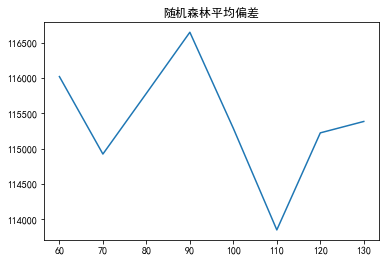

In [2]:
from sklearn.ensemble import RandomForestRegressor#随机森林回归
random_params = [60,70,80,90,100,110,120,130]
random_test_scores = []
for param in random_params:
    clf = RandomForestRegressor(n_estimators=param)
    test_score = -cross_val_score(clf, X_input, y, cv=10, scoring='neg_mean_absolute_error')
    random_test_scores.append(np.mean(test_score))
plt.plot(random_params, random_test_scores)
plt.title("随机森林平均偏差")

## Xgboost


Text(0.5,1,'Xgboost平均偏差')

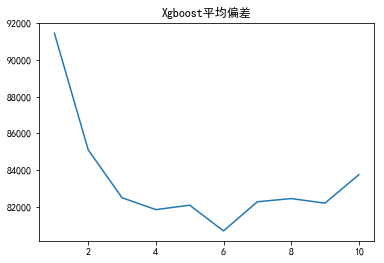

In [8]:
from xgboost import XGBRegressor
xg_params = [1,2,3,4,5,6,7,8,9,10]
xg_test_scores = []
for param in xg_params:
    clf = XGBRegressor(max_depth=param)
    test_score = -cross_val_score(clf, X_input, y, cv=10, scoring='neg_mean_absolute_error')
    xg_test_scores.append(np.mean(test_score))
plt.plot(xg_params, xg_test_scores)
plt.title("Xgboost平均偏差")

## Bagging

Text(0.5,1,'bagging平均偏差')

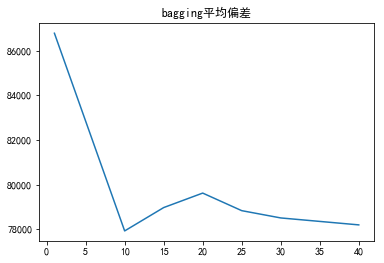

In [13]:
from sklearn.ensemble import BaggingRegressor
bag_params = [1,10,15,20,25,30,40]
bag_test_score = []
for par in bag_params:
    bag_reg = BaggingRegressor(n_estimators = par,base_estimator =  XGBRegressor(max_depth=6))
    bag_test_score.append(np.mean(-cross_val_score(bag_reg,X_input,y,cv = 10,scoring= 'neg_mean_absolute_error')))
plt.plot(bag_params,bag_test_score)
plt.title("bagging平均偏差")

## 由上图可得BaggingRegressor(n_estimators = 20,base_estimator =  XGBRegressor(max_depth=3))效果最好

## 预测新值传入格式为excel 

In [10]:
X_new = pd.DataFrame(columns = X_test.columns)
excel = pd.read_excel('./每日自变量输入.xlsx')
for i in range(len(excel.index)):
    X_new.loc[i] = 0
X_new['dayofyear'] = excel['日期'].apply(lambda x:x.dayofyear)
X_new['year'] = excel['日期'].apply(lambda x:x.year)
X_new['dayofweek'] = excel['日期'].apply(lambda x:x.dayofweek)
X_new['dayofmonth'] = excel['日期'].apply(lambda x:x.day)
excel.drop('日期',axis = 1,inplace = True)
for j in excel.index:
    for i in excel.columns:
        if i in X_new.columns:
            X_new.loc[j,i] = excel.iloc[j][i]
        else:
            str_1 = i + '_' + excel.iloc[j][i]
            X_new.loc[j,str_1] = 1
#X_read = pd.read_excel('./input4.xlsx')
#X_new[['前一天供水量','再往前一天供水量']] = np.mean(X_read[(X_read['日期']>='2018-4-25')&(X_read['日期']<='2018-5-2')]['总供水量'])

In [11]:
bag_reg = BaggingRegressor(n_estimators = 20,base_estimator =  XGBRegressor(max_depth=3))
bag_reg.fit(X_input,y)
y_new_pre = bag_reg.predict(X_new)

In [12]:
y_new_pre

array([4279349.5, 4247531. ], dtype=float32)